In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import *
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-04-06 18:32:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 172.217.13.240, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-04-06 18:32:45 (131 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.15))
model.add(LSTM(64))
model.add(Dense(total_words // 2, activation='relu', 
          kernel_regularizer = L2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 1605)              104325    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,898,963
Trainable params: 5,898,963
Non-trainable params: 0
______________________________________________

In [5]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 12s 12ms/step - loss: 7.2389 - accuracy: 0.0213
Epoch 2/100
484/484 [==============================] - 6s 12ms/step - loss: 6.4543 - accuracy: 0.0226
Epoch 3/100
484/484 [==============================] - 6s 12ms/step - loss: 6.3259 - accuracy: 0.0282
Epoch 4/100
484/484 [==============================] - 6s 12ms/step - loss: 6.2351 - accuracy: 0.0292
Epoch 5/100
484/484 [==============================] - 6s 11ms/step - loss: 6.1244 - accuracy: 0.0385
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 6.0511 - accuracy: 0.0401
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 5.9882 - accuracy: 0.0398
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.8905 - accuracy: 0.0453
Epoch 9/100
484/484 [==============================] - 6s 11ms/step - loss: 5.8061 - accuracy: 0.0499
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 5.73

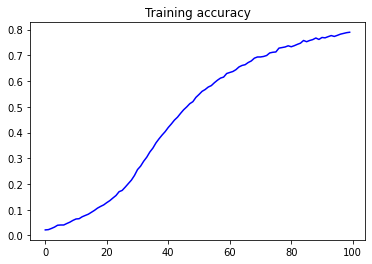

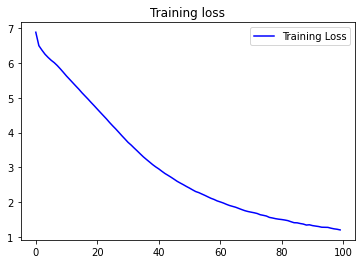

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [7]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope should stand new hate might still thought forsworn me false much much lack so much wind true part so bright foes deem'd sort seen seen forsworn me true love true true spent lie thence in me remains is assure true eyes gone prove thee do make me blind will know alone prove thee do die it confounds blindness twain twain true parts so ' be give heart thought not have i forgot do see their leisure brought so precious touch'd knife state held rehearse set new new strong remedy spent decays decays seen keep bright a frame staineth staineth staineth
